# Diabetes related genes expressed in pancreas

This notebook shows how to integrate genomic and image data resources.
This notebook looks at the question **Which diabetes related genes are expressed in the pancreas?**
Tissue and disease can be modified.


Steps:

* Query [humanmine.org](https://www.humanmine.org/humanmine), an integrated database of *Homo sapiens* genomic data using the intermine API to find the genes.
* Using the list of found genes, search in the Image Data Resource (IDR) for images linked to the genes, tissue and disease.

 
We use the intermine API and the IDR API. This notebook is inspired by [Workshop_Pax6Workflow](https://github.com/intermine/intermine-ws-python-docs/blob/master/Workshop_Pax6Workflow.ipynb).

## Summary:
![Overview](./includes/HumanMineIDR.png)

## Settings:


### Auxiliary libraries used
* [nb_conda_kernels](https://github.com/Anaconda-Platform/nb_conda_kernels): Enables a Jupyter Notebook or JupyterLab application in one conda environment to access kernels for Python, R, and other languages found in other environments.
* [jupyter_contrib_nbextensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/index.html): Package containing a collection of community-contributed unofficial extensions that add functionality to the Jupyter notebook.

## Launch

### binder

If not already running, you can launch by clicking on the logo [![Binder <](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/IDR/idr-notebooks/master?urlpath=notebooks%2Fhumanmine.ipynb)

### run locally using Docker and repo2docker

With ``jupyter-repo2docker`` installed, run:

```
git clone https://github.com/IDR/idr-notebooks.git
cd idr-notebooks
repo2docker .
```

### Install dependencies if required
The cell below will install dependencies if you choose to run the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true).

In [24]:
%pip install intermine

Note: you may need to restart the kernel to use updated packages.


### Import libraries 

In [25]:
# libraries to interact with intermine
from intermine.webservice import Service

# libraries to interact with IDR
import requests
import json

## Search for genes in HumanMine

We first define the output columns, then add the constraints i.e. specify the tissue and the disease.

In [26]:
TISSUE = "Pancreas" # "Cerebellum" # "little brain"
DISEASE = "diabetes" #"MICROCEPHALY"

In [27]:
service = Service("https://www.humanmine.org/humanmine/service")

In [28]:
query = service.new_query("Gene")

In [29]:
query.add_view(
    "primaryIdentifier", "symbol", "proteinAtlasExpression.cellType",
    "proteinAtlasExpression.level", "proteinAtlasExpression.reliability",
    "proteinAtlasExpression.tissue.name"
)

We look for those genes in the specified tissue and that are also associated with the specified disease.

In [30]:
query.add_constraint("proteinAtlasExpression.tissue.name", "=", TISSUE)
query.add_constraint("proteinAtlasExpression.level", "ONE OF", ["Medium", "High"])
query.add_constraint("organism.name", "=", "Homo sapiens")
query.add_constraint("diseases.name", "CONTAINS", DISEASE)

<BinaryConstraint: Gene.diseases.name CONTAINS diabetes>

Collect the genes

In [31]:
upin_tissue = set()
for row in query.rows():
    upin_tissue.add(row["symbol"])
genes = sorted(upin_tissue, reverse=True)

Print out the list of genes

In [32]:
for i, a in enumerate(genes):
    print(a, end=' ')
    if i % 8 == 7: 
        print("")

YIPF5 WFS1 VEGFA TCF7L2 TBC1D4 SOD2 SLC30A8 PTPN22 
PDX1 MIA3 KCNJ11 IRS2 IRS1 INSR INS IGF2BP2 
IER3IP1 HNF4A HNF1B HMGA1 HFE GPD2 GCK ENPP1 
EIF2AK3 DNAJC3 CEL CAPN10 APPL1 AKT2 ABCC8 

## Search for images in IDR associated to the genes found in HumanMine

From the list of genes found using the intermine API, we are now looking in [Image Data Resource](https://idr.openmicroscopy.org/) for studies linked to those genes and with **TISSUE** as a ``Sample Type``.

In [33]:
TYPE = "gene"
SAMPLE_TYPE = "tissue"
EXPRESSION_KEY = "Expression Pattern Description"
EXPRESSION = "Islets" # "Brain"
STAGE = "Developmental Stage"
KEY = "Gene Symbol"
PART_KEY = "Organism Part"
PATHOLOGY_KEY = "Pathology"
PATHOLOGY_NORMAL_VALUE = "Normal"

### Set up base URLS so can use shorter variable names later on

In [34]:
SEARCH_URL = "https://idr-testing.openmicroscopy.org/searchengine/api/v1/resources/{type}/search/"
KEY_VALUE_SEARCH = SEARCH_URL + "?key={key}&value={value}"

### Set up where to query and session

In [35]:
INDEX_PAGE = "https://idr-testing.openmicroscopy.org/webclient/?experimenter=-1"

# create http session
with requests.Session() as session:
    request = requests.Request('GET', INDEX_PAGE)
    prepped = session.prepare_request(request)
    response = session.send(prepped)
    if response.status_code != 200:
        response.raise_for_status()

### Search studies
Search the studies related to the list of genes found in the HumanMine resource.

In [36]:
%%time
import collections
from collections import defaultdict

results = {}
for gene in genes:
    qs1 = {'type': 'image', 'key': KEY, 'value': gene}
    url = KEY_VALUE_SEARCH.format(**qs1)
    json = session.get(url).json()
    images = json['results']['results']
    results[gene] = images

CPU times: user 1.13 s, sys: 415 ms, total: 1.55 s
Wall time: 11.9 s


**First we filter images with the development stage.**

In [37]:
development_stage = {}
for k in results:
    images = results[k]
    result_images = defaultdict(list)
    for image in images:
        values = image["key_values"]
        stage = ""
        for v in values:
            name = v["name"]
            value = v['value']
            if name == STAGE:
                stage = value
            if name == EXPRESSION_KEY and EXPRESSION in value:
                result_images[stage].append(image["id"])
    development_stage[k] = result_images.items()

In [38]:
print(development_stage)

{'YIPF5': dict_items([]), 'WFS1': dict_items([]), 'VEGFA': dict_items([]), 'TCF7L2': dict_items([]), 'TBC1D4': dict_items([]), 'SOD2': dict_items([]), 'SLC30A8': dict_items([]), 'PTPN22': dict_items([]), 'PDX1': dict_items([('15PCW', [9841210, 9841211]), ('9PCW', [9841212, 9841213, 9841218, 9841219]), ('CS21', [9841214, 9841215]), ('CS16', [9841216, 9841217])]), 'MIA3': dict_items([]), 'KCNJ11': dict_items([]), 'IRS2': dict_items([]), 'IRS1': dict_items([]), 'INSR': dict_items([]), 'INS': dict_items([('15PCW', [9839153, 9839154])]), 'IGF2BP2': dict_items([]), 'IER3IP1': dict_items([]), 'HNF4A': dict_items([]), 'HNF1B': dict_items([]), 'HMGA1': dict_items([]), 'HFE': dict_items([]), 'GPD2': dict_items([]), 'GCK': dict_items([]), 'ENPP1': dict_items([]), 'EIF2AK3': dict_items([]), 'DNAJC3': dict_items([]), 'CEL': dict_items([]), 'CAPN10': dict_items([]), 'APPL1': dict_items([]), 'AKT2': dict_items([]), 'ABCC8': dict_items([])}


## Display the images
Display the images associated to the genes.

In [39]:
BASE_URL = "https://idr.openmicroscopy.org/webclient"
IMAGE_DATA_URL = BASE_URL + "/render_thumbnail/{id}"
LINK_URL = BASE_URL + "/?show=image-{id}"

## Display the images with development stage
Click on the thumbnail to open the image in IDR.

In [40]:
# Display the images
from ipywidgets import AppLayout, widgets

table_widget = widgets.HTML("")

html = "<table>"
for gene in development_stage:
    images = development_stage[gene]
    if len(images) > 0:
        html += '<tr><td><h2>Gene: '+gene+'</h2></td></tr><tr>'
        for k, v in images:
            html += '<tr><td><h4>Developmental stage: '+k+'</h4></td></tr><tr>'
            for i in v:
                qs = {'id': i}
                url = IMAGE_DATA_URL.format(**qs)
                url_link = LINK_URL.format(**qs)
                html += '<td><a href="'+url_link+'" target="_blank"><img src="'+url+'"/></a></td>'
            html += "</tr>"
        html += "</tr>"
html += "</table>"

table_widget.value = html
AppLayout(header=None,
          left_sidebar=None,
          center=table_widget,
          right_sidebar=None,
          footer=None)

AppLayout(children=(HTML(value='<table><tr><td><h2>Gene: PDX1</h2></td></tr><tr><tr><td><h4>Developmental stag…

**Now we filter images with a given Organism Part value**.

We explore the images associated to the gene **PDX1** with abnormal pathology status.

In [41]:
pathology_images = {}
for k in results:
    images = results[k]
    result_images = defaultdict(list)
    for image in images:
        values = image["key_values"]
        part = None
        for v in values:
            name = v["name"]
            value = v['value']
            if PART_KEY in name and (TISSUE or EXPRESSION in value):
                part = value
        for v in values:
            name = v["name"]
            value = v['value']
            if part is not None and name == PATHOLOGY_KEY:
                if PATHOLOGY_NORMAL_VALUE in value:
                    result_images[PATHOLOGY_NORMAL_VALUE].append(image["id"])
                else:
                    result_images[value].append(image["id"])
    pathology_images[k] = result_images.items()

**Plot the disease vs number of images found**

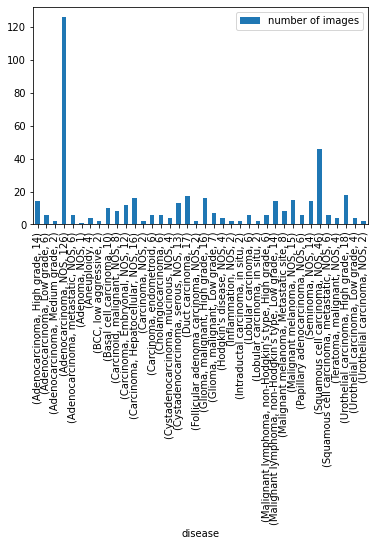

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
disease_map = {}
gene = "PDX1"
images = pathology_images[gene]
if len(images) == 0:
    print("No images found")
else:
    for k, v in images:
        if k != PATHOLOGY_NORMAL_VALUE:
            disease_map[k] = len(v)

    disease_ordered = collections.OrderedDict(sorted(disease_map.items()))
    df = pd.DataFrame({'disease':disease_ordered.items(),
                       'number of images':disease_ordered.values()})
    df.plot(kind='bar',x='disease',y='number of images')

**Select the disease and display the associated images**
Click on the thumbnail to open the image in IDR.

In [51]:
from ipywidgets import GridspecLayout, widgets

increase = 8
max_value = increase
min_value = 0

disease = ""

def display_images(images, min, max):
    html = "<table>"
    html += '<tr>'
    if min < 0:
        min = 0
    if max >= len(images):
        max = len(images)

    
    for i in images[min:max]:
        qs = {'id': i}
        url = IMAGE_DATA_URL.format(**qs)
        url_link = LINK_URL.format(**qs)
        html += '<td><a href="'+url_link+'" target="_blank"><img src="'+url+'"/></a>&nbsp;</td>'
    html += "</tr>"
    html += "</table>"
    html_widget.value = html
    
    # Set the number of images found
    count_widget.value = "<b>Number of images found: " + str(len(images)) + "</b>"
    
def on_selection_change(change):
    global disease
    if change['name'] == 'value':
        values = get_images(change['new']) 
        if values is None:
            return
        disease = change['new']
        min_value = 0
        max_value = increase 
        display_images(values, min_value, max_value)
                
def get_images(disease):
    for k, v in images:
        if k == disease:
            return v
    return None
    
def on_click_next(b):
    global min_value
    global max_value
    max_value = max_value + increase
    min_value = min_value + increase
    values = get_images(disease)
    button_previous.disabled = False
    if values is None:
        return
    if max_value > len(values):
        button_next.disabled = True
        
    display_images(values, min_value, max_value)

def on_click_previous(b):
    global min_value
    global max_value
    max_value = max_value - increase
    min_value = min_value - increase
    button_next.disabled = False
    if min_value <= 0:  # reset 
        min_value = 0
        max_value = increase
        button_previous.disabled = True
    values = get_images(disease)
    if values is not None:
        display_images(values, min_value, max_value)
            
def dropdown_widget(disease_list,
                    dropdown_widget_name,
                    displaywidget=False):

    selection = widgets.Dropdown(
        options=disease_list,
        value=disease_list[0],
        description=dropdown_widget_name,
        disabled=False,
    )
    selection.observe(on_selection_change)
    display_images(get_images(selection.value), min_value, max_value)
    return selection

disease_list = list(disease_ordered.keys())
disease = disease_list[0]
gene_widget = widgets.HTML("")
count_widget = widgets.HTML("")
html_widget = widgets.HTML("")
disease_box = dropdown_widget(
    disease_list,
    'Disease: ', True
)

button_next = widgets.Button(description="Next>>")
button_next.on_click(on_click_next)

button_previous = widgets.Button(description="<<Previous", disabled=True)
button_previous.on_click(on_click_previous)

gene_widget.value = "Gene: <b>" + gene + "</b>"

grid = GridspecLayout(3, 3)
grid[0, 0] = gene_widget
grid[0, 1] = disease_box
grid[0, 2] = count_widget
grid[2, 0] = button_previous
grid[1, :] = html_widget
grid[2, 2] = button_next
grid


GridspecLayout(children=(HTML(value='Gene: <b>PDX1</b>', layout=Layout(grid_area='widget001')), Dropdown(descr…

### License (BSD 2-Clause)¶

Copyright (C) 2021-2022 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. 